This notebook contains the analysis of the final MaxFuse integration, as well as the neighborhood analysis

In [342]:
import anndata
import pandas as pd
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import zscore
from matplotlib import colors

%load_ext jupyter_black

protein_map = pd.read_csv(
    "2022_11_16_Protein-Gene mapping_markers for data integration.csv"
)

# remove non-relevant antigens
protein_map = protein_map[protein_map["Comment"].isnull()]
# remove whitespace from marker names
protein_map["Antigen (CODEX)"] = protein_map["Antigen (CODEX)"].str.strip()
protein_map["Gene"] = protein_map["Gene"].str.strip()

marker_columns = [
    "CD56.Cytoplasm.Intensity",
    "CD161.Cytoplasm.Intensity",
    "TCRValpha.Cytoplasm.Intensity",
    "CD39.Cytoplasm.Intensity",
    "CD25.Cytoplasm.Intensity",
    "CD57.Cytoplasm.Intensity",
    "CD40.Cytoplasm.Intensity",
    "ICOS.Cytoplasm.Intensity",
    "CD3.Cytoplasm.Intensity",
    "CD62L.Cytoplasm.Intensity",
    "LYVE.1.Cytoplasm.Intensity",
    "CD45RO.Cytoplasm.Intensity",
    "IL18Ra.Cytoplasm.Intensity",
    "PD.L1.Cytoplasm.Intensity",
    "CD45.Cytoplasm.Intensity",
    "CD34.Cytoplasm.Intensity",
    "CD163.Cytoplasm.Intensity",
    "Ki67.Nucleus.Intensity",
    "CD19.Cytoplasm.Intensity",
    "CD38.Cytoplasm.Intensity",
    "CD279.Cytoplasm.Intensity",
    "CD11c.Cytoplasm.Intensity",
    "CD8.Cytoplasm.Intensity",
    "CD11b.Cytoplasm.Intensity",
    "CD16.Cytoplasm.Intensity",
    "FoxP3.Nucleus.Intensity",
    "CD69.Cytoplasm.Intensity",
    "CD15.Cytoplasm.Intensity",
    "HNFalpha.Nucleus.Intensity",
    "pancytokeratin.Cytoplasm.Intensity",
    "HLADR.Cytoplasm.Intensity",
    "CD45RA.Cytoplasm.Intensity",
    "aSMA.Cytoplasm.Intensity",
    "CD4.Cytoplasm.Intensity",
    "CD66b.Cytoplasm.Intensity",
    "CD68.Cytoplasm.Intensity",
    "EPCAM.Cytoplasm.Intensity",
]

markers = []
for column in marker_columns:
    if "Intensity" in column:
        markers.append("-".join(column.split(".")[:-2]))

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Evaluate transferred labels

In [343]:
# Subset of markers relevant for CD8 cells
MARKERS_TO_PLOT = [
    "CD56",
    "CD161",
    "CD39",
    "CD25",
    "CD57",
    "ICOS",
    "CD62L",
    "IL18Ra",
    "Ki67",
    "CD38",
    "CD279",
    "CD16",
    "FoxP3",
    "CD69",
    "HLADR",
]

c9_CD8_PD1lo_Cytotoxic : 47357
c5_CD8_PD1lo_Mem 1 : 36992
c4_CD8_PD1hi_TEX : 46241
c14_CD8_PD1hi Tpex : 15968
c13_CD8_PD1lo Mem 2 : 20692
c7_CD8_PD1lo_TREM : 35471
c12_CD8_PD1hi_Cytotoxic : 13882
c1_CD8_PD1lo effector : 19719


<Axes: >

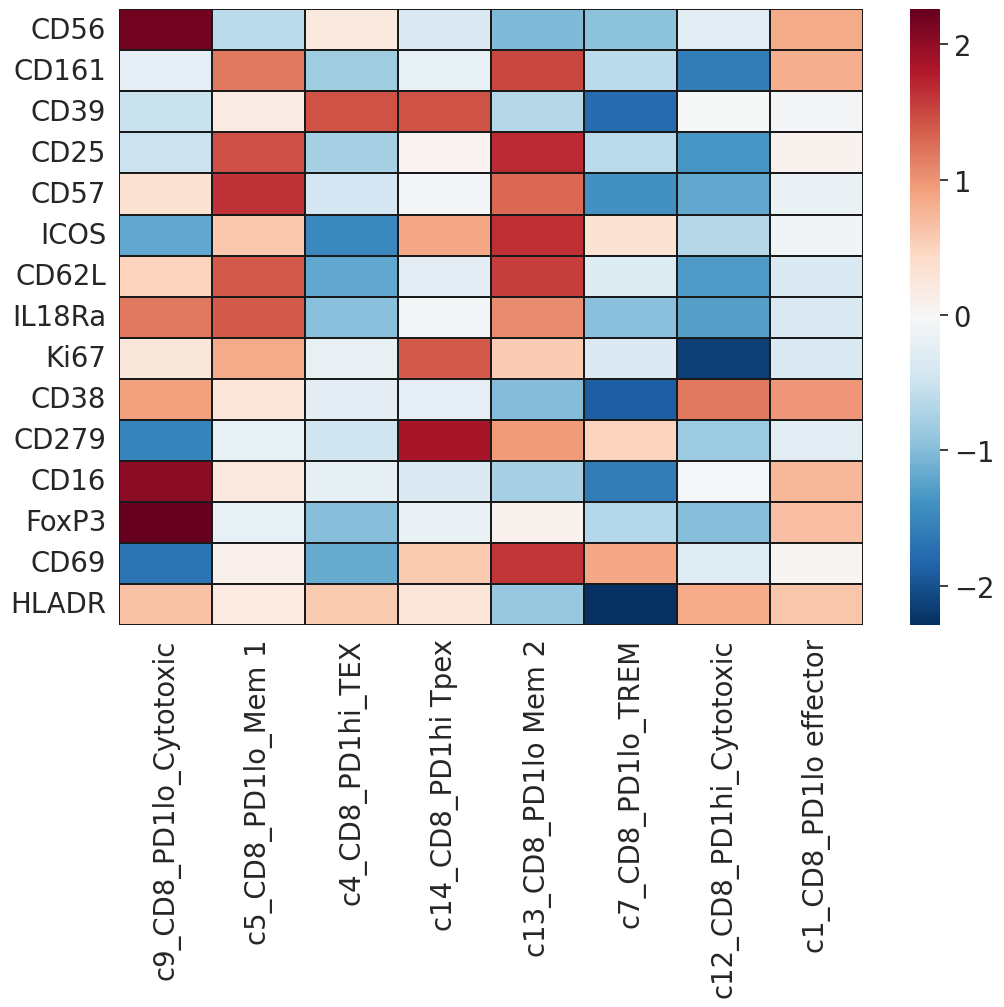

In [344]:
mean_expressions = []
clusters = []
for cluster in integrated_adata.obs["Cluster label"].unique():

    if pd.isna(cluster):
        continue
    cells = integrated_adata[
        integrated_adata.obs["Cluster label"] == cluster, MARKERS_TO_PLOT
    ]
    print(cluster, ":", cells.shape[0])
    mean_expressions.append(cells.X.mean(axis=0))
    clusters.append(cluster)
mean_expressions = np.array(mean_expressions).T

mean_expressions = zscore(mean_expressions, axis=1)


plt.figure(figsize=(12, 8))
sns.heatmap(
    mean_expressions,
    xticklabels=clusters,
    yticklabels=MARKERS_TO_PLOT,
    linewidth=0.1,
    linecolor="k",
    cmap="RdBu_r",
)

In [345]:
adata = anndata.read("CODEX_cd8.h5ad")
sc_adata = anndata.read("adata_CD8_velocity_all.h5ad")

markers = []
for column in marker_columns:
    if "Intensity" in column:
        markers.append("-".join(column.split(".")[:-2]))
markers

protein_map_dict = {}
for marker in markers:
    gene_aliases = protein_map[protein_map["Antigen (CODEX)"] == marker][
        "Gene"
    ].values.reshape(-1)
    # print(marker, gene_aliases)
    protein_map_dict[marker] = []
    for gene_name in gene_aliases:
        split = gene_name.split(",")
        for name in split:
            protein_map_dict[marker].append(name.strip())


markers_to_keep = []
genes_to_keep = []
for key, values in protein_map_dict.items():
    for gene in values:  # if protein matches to more than one gene
        if (
            gene in sc_adata.var[sc_adata.var["highly_variable"]].index.values
        ):  # keep only higly variable genes
            genes_to_keep.append(gene)
            markers_to_keep.append(key)  # repeat marker

/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


<Axes: >

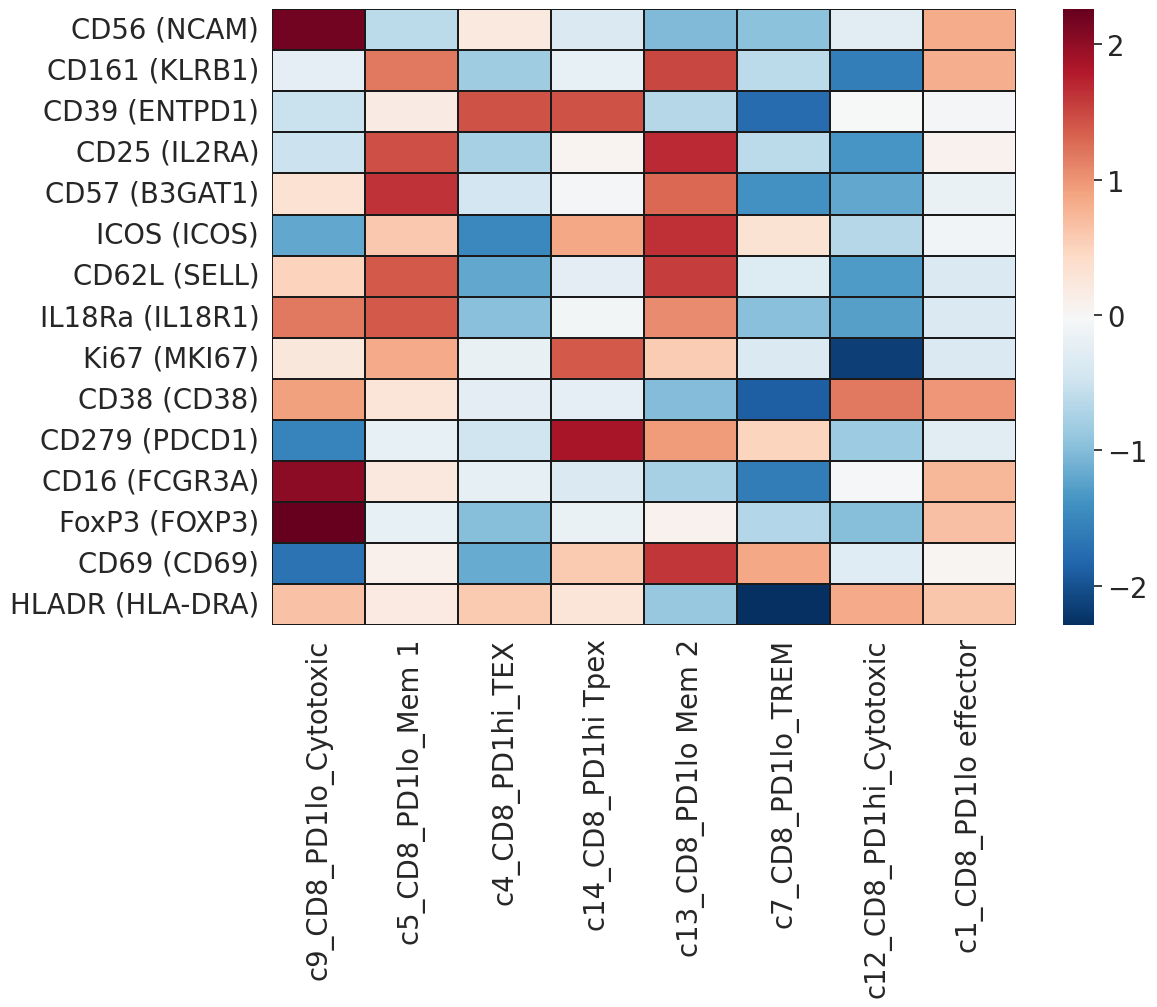

In [346]:
# Plot protein expression including associated gene names
gene_names = []
gene_names_full = []
for marker in MARKERS_TO_PLOT:

    gene_names.append(protein_map_dict[marker])
    # gene_names_full.append(protein_map_dict[marker] + ' (' + marker + ')')

gene_names_full = [g for glist in gene_names for g in glist]
gene_names = [g[0] for g in gene_names]

marker_and_gene_names = [
    marker_name + f" ({gene_name})"
    for (marker_name, gene_name) in zip(MARKERS_TO_PLOT, gene_names)
]

plt.figure(figsize=(12, 8))
sns.heatmap(
    mean_expressions,
    xticklabels=clusters,
    yticklabels=marker_and_gene_names,
    linewidth=0.1,
    linecolor="k",
    cmap="RdBu_r",
)

In [362]:
gene_names = []
gene_names_full = []
for marker in MARKERS_TO_PLOT:
    gene_names.append(protein_map_dict[marker])

gene_names_full = [g for glist in gene_names for g in glist]
gene_names = [g for g in gene_names]
gene_names = sum(gene_names, [])

In [363]:
genes_to_plot = []

for g in gene_names:
    if g in sc_adata.var_names:
        genes_to_plot.append(g)

mean_expressions_sc = []
clusters_sc = []

for cluster in clusters:

    if pd.isna(cluster):
        continue
    cells = sc_adata[sc_adata.obs["Cluster label"] == cluster, genes_to_plot]
    print(cluster, ":", cells.shape[0])
    mean_expressions_sc.append(cells.X.mean(axis=0))
    clusters_sc.append(cluster)

mean_expressions_sc = np.squeeze(np.array(mean_expressions_sc).T)

mean_expressions_sc = zscore(mean_expressions_sc, axis=1)

c9_CD8_PD1lo_Cytotoxic : 1227
c5_CD8_PD1lo_Mem 1 : 2085
c4_CD8_PD1hi_TEX : 1926
c14_CD8_PD1hi Tpex : 478
c13_CD8_PD1lo Mem 2 : 680
c7_CD8_PD1lo_TREM : 1563
c12_CD8_PD1hi_Cytotoxic : 819
c1_CD8_PD1lo effector : 2988


<Axes: >

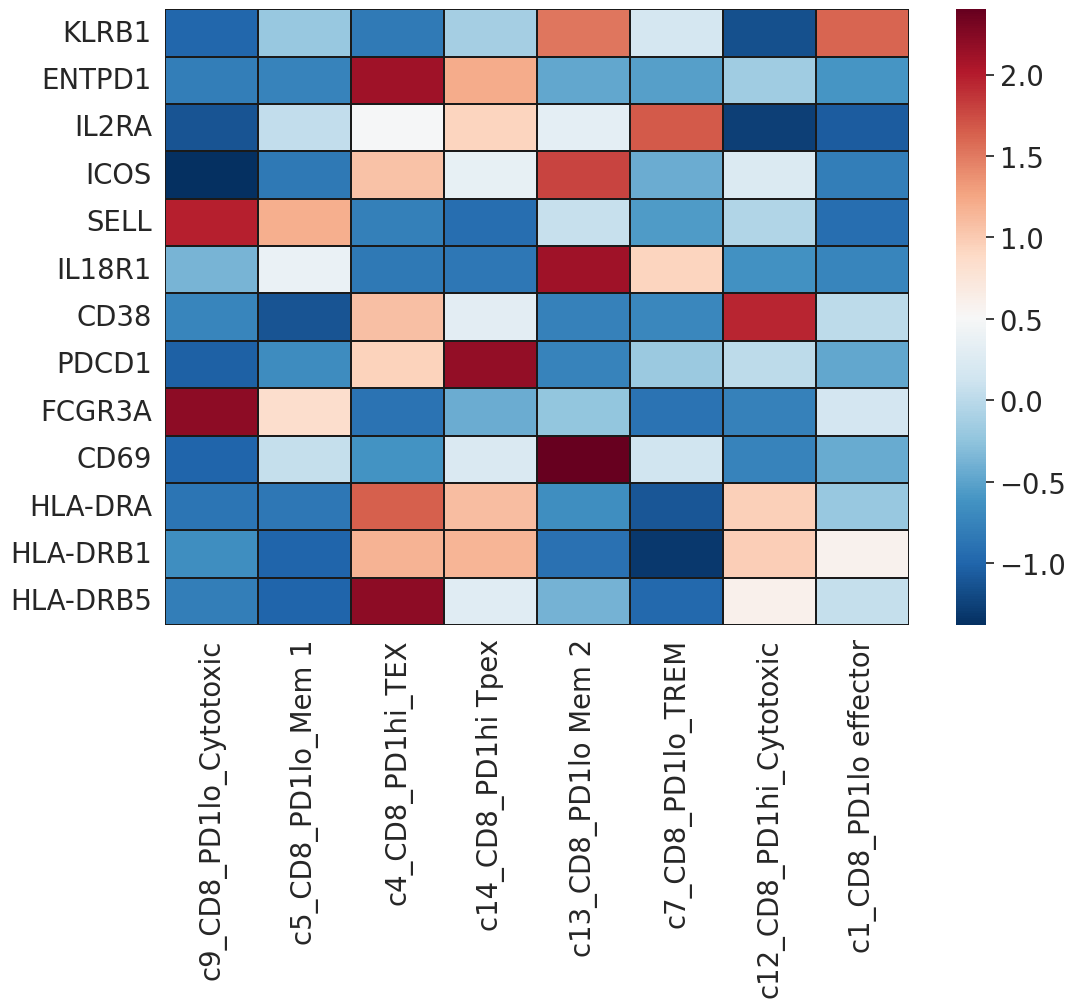

In [367]:
indices = []
for i, name in enumerate(gene_names):
    if name in genes_to_plot:
        indices.append(i)

plt.figure(figsize=(12, 8))
sns.heatmap(
    mean_expressions_sc,
    xticklabels=clusters,
    yticklabels=np.array(gene_names)[indices],
    linewidth=0.1,
    linecolor="k",
    cmap="RdBu_r",
)

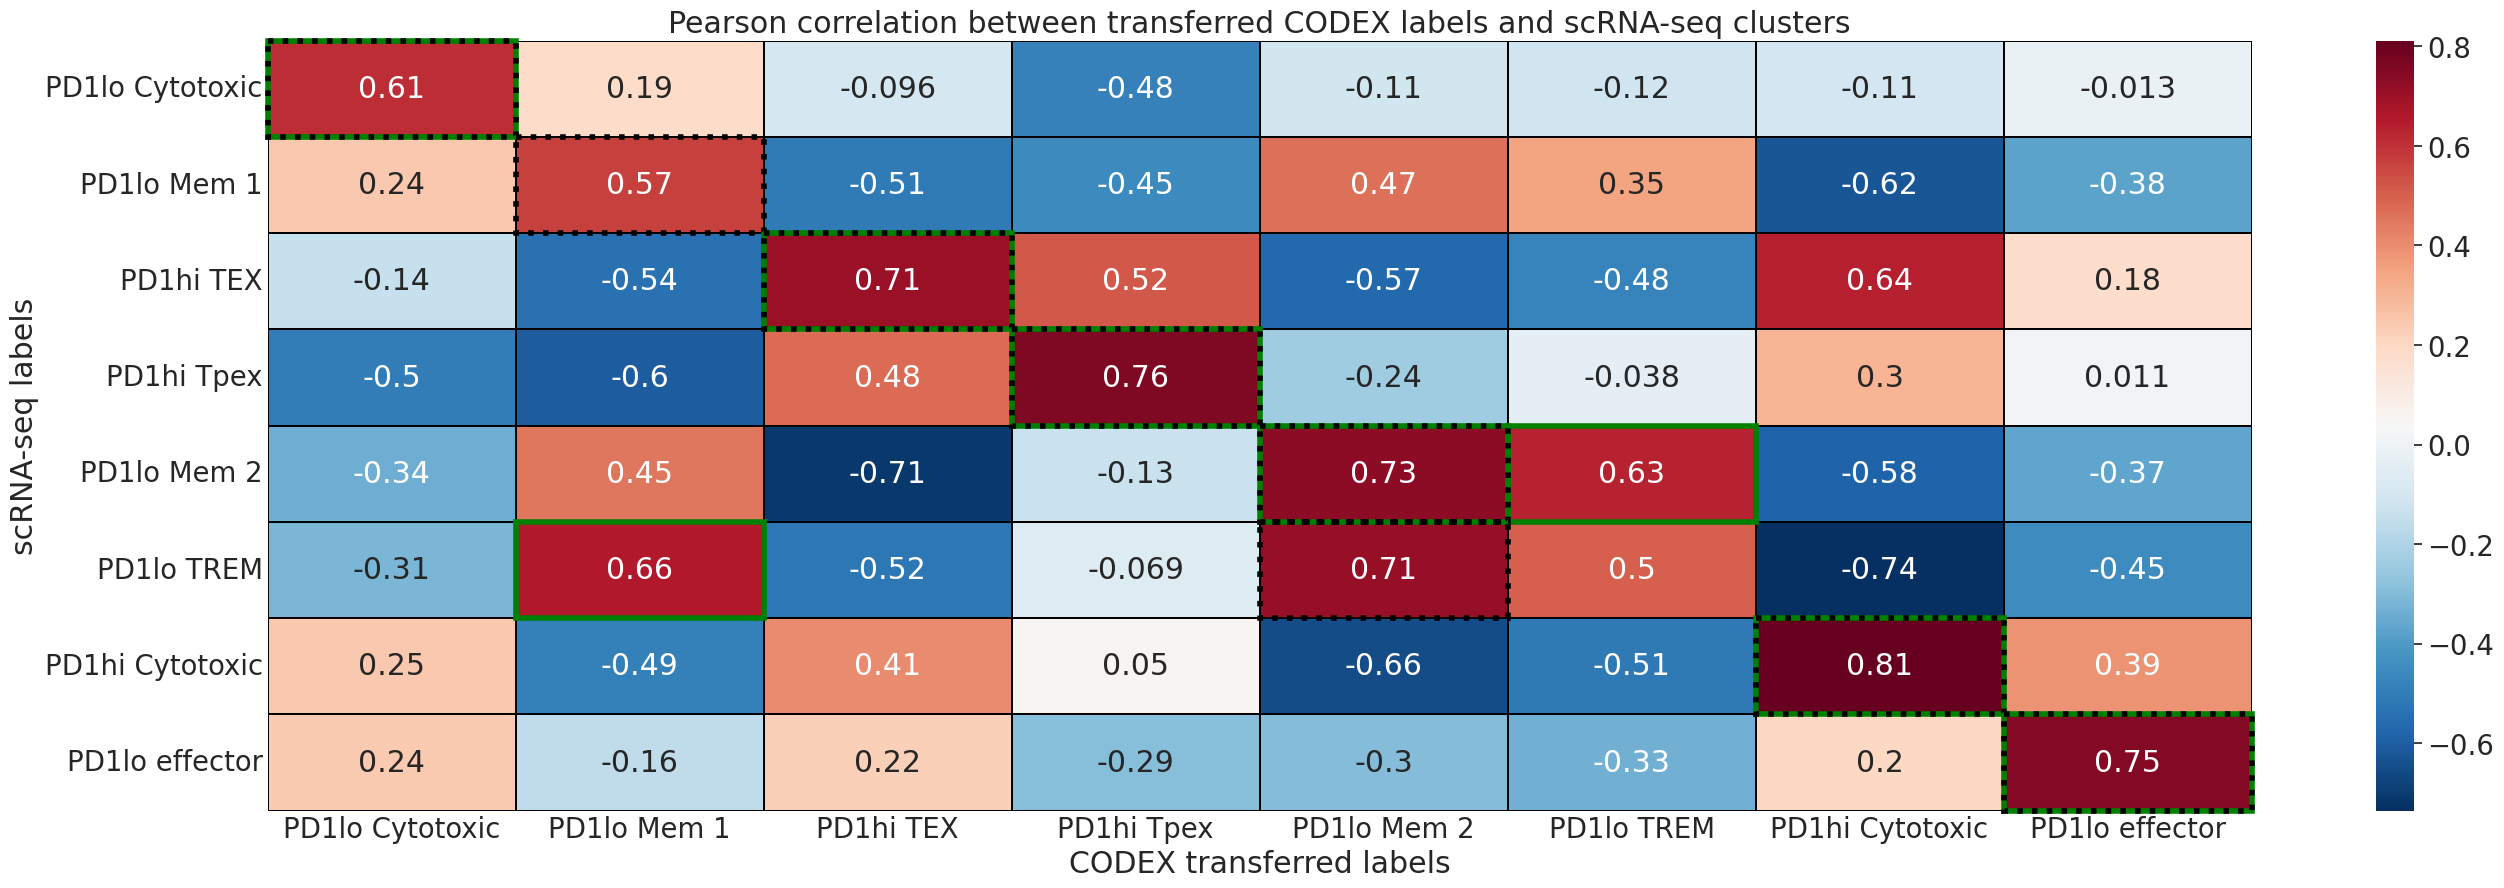

In [371]:
# Plot correlations between CODEX and scRNA-seq clusters
clusters_names = [" ".join(c.split("_")[2:]) for c in clusters]

# Repeat the last protein to get the same shape
indices = [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 14, 14]

dist_x_corr = pairwise_distances(
    X=mean_expressions_sc.T, Y=mean_expressions[indices].T, metric="correlation"
)
dist_x_corr = -dist_x_corr + 1

from matplotlib.patches import Rectangle

dist_x_corr_to_keep = dist_x_corr

plt.figure(figsize=(32, 10))
sns.set(font_scale=1.8)
ax = sns.heatmap(
    dist_x_corr,
    annot=True,
    linewidths=0.2,
    linecolor="black",
    cmap="RdBu_r",
    xticklabels=np.array(clusters_names),
    yticklabels=np.array(clusters_names),
)

ax.set_xlabel("CODEX transferred labels")
ax.set_ylabel("scRNA-seq labels")

for cluster in range(dist_x_corr.shape[1]):

    cluster_sc = np.argmax(dist_x_corr[:, cluster]).item()

    x, y, w, h = cluster, cluster_sc, 1, 1

    ax.add_patch(
        Rectangle((x, y), w, h, fill=False, edgecolor="green", lw=4, clip_on=False)
    )

    ax.tick_params(length=0)

for cluster in range(dist_x_corr.shape[0]):

    cluster_codex = np.argmax(dist_x_corr[cluster, :]).item()

    x, y, w, h = cluster_codex, cluster, 1, 1

    ax.add_patch(
        Rectangle(
            (x, y),
            w,
            h,
            fill=False,
            edgecolor="black",
            lw=4,
            clip_on=False,
            linestyle="dotted",
        )
    )

    ax.tick_params(length=0)

plt.title(
    r"Pearson correlation between transferred CODEX labels and scRNA-seq clusters"
)
plt.show()

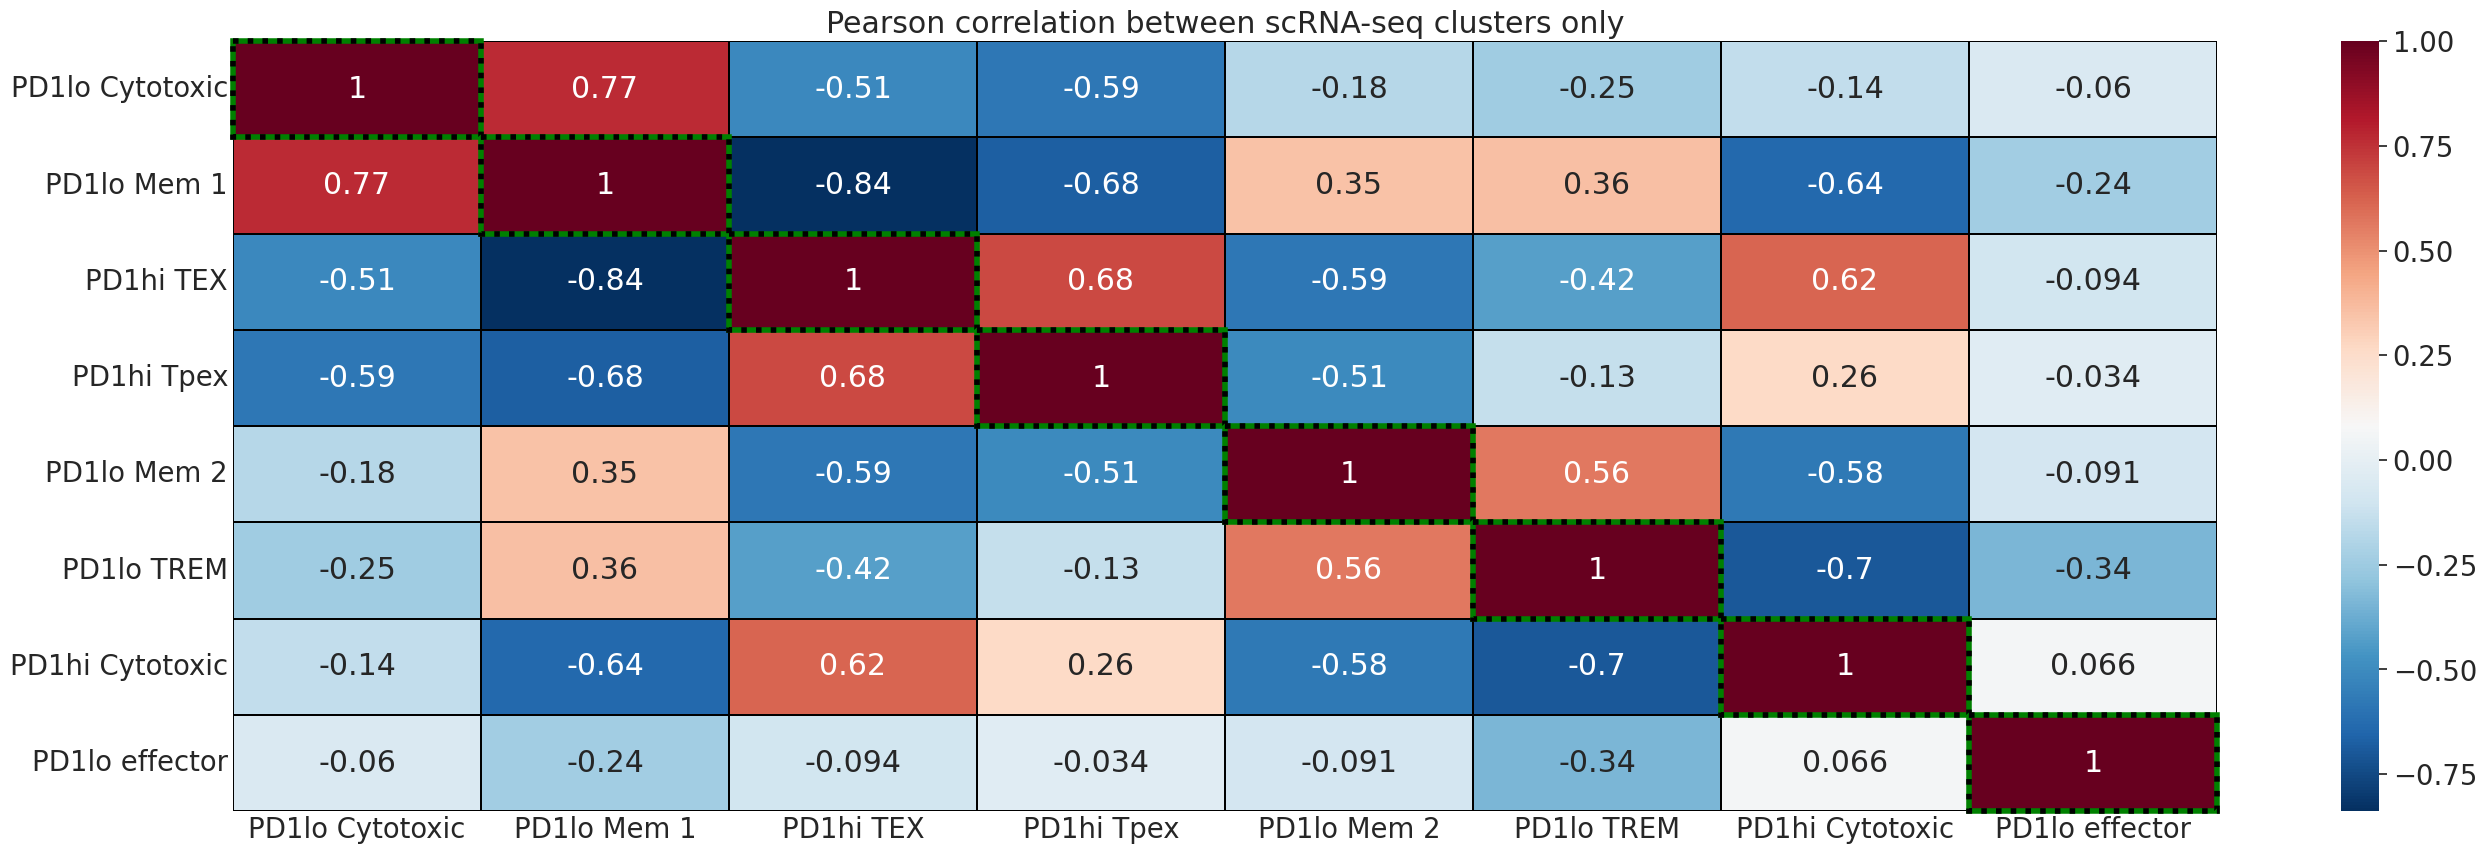

In [372]:
# Plot correlations bewteen scRNA-seq clusters
dist_x_corr = pairwise_distances(X=mean_expressions_sc.T, metric="correlation")
dist_x_corr = (
    -dist_x_corr + 1
)  # turn correlation distance into actual correlation values

from matplotlib.patches import Rectangle

dist_x_corr_to_keep = dist_x_corr

sns.set(font_scale=1.8)
plt.figure(figsize=(32, 10))
ax = sns.heatmap(
    dist_x_corr,
    annot=True,
    linewidths=0.2,
    linecolor="black",
    cmap="RdBu_r",
    xticklabels=np.array(clusters_names),
    yticklabels=np.array(clusters_names),
)

for cluster in range(dist_x_corr.shape[1]):

    cluster_sc = np.argmax(dist_x_corr[:, cluster]).item()

    x, y, w, h = cluster, cluster_sc, 1, 1

    ax.add_patch(
        Rectangle((x, y), w, h, fill=False, edgecolor="green", lw=4, clip_on=False)
    )

    ax.tick_params(length=0)

for cluster in range(dist_x_corr.shape[0]):

    cluster_codex = np.argmax(dist_x_corr[cluster, :]).item()

    x, y, w, h = cluster_codex, cluster, 1, 1

    ax.add_patch(
        Rectangle(
            (x, y),
            w,
            h,
            fill=False,
            edgecolor="black",
            lw=4,
            clip_on=False,
            linestyle="dotted",
        )
    )

    ax.tick_params(length=0)

plt.title(r"Pearson correlation between scRNA-seq clusters only")
plt.show()

# Neighborhood analysis

In [ ]:
# Read dataframe containing all CODEX data
df = pd.read_csv("HCC_nojunk.csv")

df["X_mean"] = (df["XMin"] + df["XMax"]) / 2.0
df["Y_mean"] = (df["YMin"] + df["YMax"]) / 2.0
df["index"] = pd.Index(df["index"], dtype=str)
df = df.set_index("index")

# Read CODEX CD8 T cell data with transferred labels
integrated_adata = anndata.read("adata_cd8_codex_label_transfer_good.h5ad")

# Fix index so it matches with the whole codex dataframe
integrated_adata.obs.loc[:, "index"] = pd.Index(integrated_adata.obs["index"])

integrated_adata.obs.loc[:, "index"] = pd.Index(
    integrated_adata.obs["index"], dtype=str
)

integrated_adata.obs = integrated_adata.obs.set_index("index")

# Integrate CODEX and transferred scRNA-seq labels into one column
df["Cluster label"] = df["Class0"].copy()
df.loc[integrated_adata.obs.index, "Cluster label"] = integrated_adata.obs[
    "Cluster label"
]

df.loc[df["Cluster label"].isnull(), "Cluster label"] = df[
    df["Cluster label"].isnull()
]["Class0"]

df.to_csv("HCC_nojunk_CD8_integrated_good.csv")

In [33]:
X = df.loc[:, marker_columns].values
codex_adata = anndata.AnnData(X=X, obs=df)

codex_adata.obsm["X_spatial"] = np.stack(
    [codex_adata.obs["X_mean"].values, codex_adata.obs["Y_mean"].values], axis=1
)

codex_adata.obs = df

codex_adata.write("codex_adata_with_integration_full.h5ad")

In [37]:
# select only_immune_cells
codex_adata_immune = codex_adata[
    codex_adata.obs["CD45.Positive.Classification"] == 1
]  # select only_immune_cells
scp.pp.neighbors(
    codex_adata, n_neighbors=40, use_rep="X_spatial", key_added="40_neighbors"
)

In [38]:
# compute neighborhoods
scp.pp.neighbors(
    codex_adata_immune, n_neighbors=30, use_rep="X_spatial", key_added="30_neighbors"
)

In [39]:
scp.pp.neighbors(
    codex_adata_immune, n_neighbors=20, use_rep="X_spatial", key_added="20_neighbors"
)

In [40]:
codex_adata_immune.write("immune_codex_adata_with_integration.h5ad")

In [83]:
neighbor_indices = np.nonzero(
    codex_adata_immune.obsp["40_neighbors_connectivities"][0].toarray().flatten()
)[0]

In [84]:
neighbor_celltype_dfs = []

# Select neighbors for the CD* celltypes only and count the number of celltypes
for cluster_label in integrated_adata.obs["Cluster label"].unique():
    if pd.isna(cluster_label):
        continue

    indices = codex_adata_immune.obs["Cluster label"] == cluster_label

    cell_indices = np.argwhere(indices).flatten()
    print(cluster_label)

    neighbors = codex_adata_immune.obsp["40_neighbors_distances"][cell_indices]

    neighbor_indices = np.nonzero(neighbors)

    cell_indices = codex_adata_immune.obs.index[cell_indices]
    celltype_df = pd.DataFrame(
        {
            "cell_id": cell_indices[neighbor_indices[0]],
            "neighbor_ct": codex_adata_immune.obs.iloc[neighbor_indices[1]][
                "Cluster label"
            ],
        }
    )

    celltype_df = (
        celltype_df.value_counts(["cell_id", "neighbor_ct"])
        .reset_index()
        .pivot(index="cell_id", columns="neighbor_ct", values="count")
    ).fillna(0)

    neighbor_celltype_dfs.append(celltype_df)

c9_CD8_PD1lo_Cytotoxic
c5_CD8_PD1lo_Mem 1
c4_CD8_PD1hi_TEX
c14_CD8_PD1hi Tpex
c13_CD8_PD1lo Mem 2
c7_CD8_PD1lo_TREM
c12_CD8_PD1hi_Cytotoxic
c1_CD8_PD1lo effector


In [85]:
full_neighbor_df = pd.concat(neighbor_celltype_dfs)

In [88]:
#normalize the neighbor counts
full_neighbor_df_norm = full_neighbor_df.div(full_neighbor_df.sum(axis=1), axis=0) * 100

In [89]:
# Add celltype, Tissue and Patient data for each cell chosen as reference
full_neighbor_df_norm["Cluster label"] = codex_adata_immune[
    full_neighbor_df_norm.index
].obs["Cluster label"]

full_neighbor_df_norm["Tissue"] = codex_adata_immune[full_neighbor_df_norm.index].obs[
    "Tissue"
]

full_neighbor_df_norm["Patient"] = codex_adata_immune[full_neighbor_df_norm.index].obs[
    "Patient"
]

len(full_neighbor_df_norm.columns)

32

In [90]:
full_neighbor_df_norm.head()

neighbor_ct,B cells CD38+,B cells CD45RA,B cells PD-L1+,Granulocytes CD38+,Granulocytes CD38-,Kupffer cells,M2 Macrophages PD-L1+,M2 Macrophages PD-L1-,MAITs,MHCII APCs,...,c4_CD8_PD1hi_TEX,c5_CD8_PD1lo_Mem 1,c7_CD8_PD1lo_TREM,c9_CD8_PD1lo_Cytotoxic,c12_CD8_PD1hi_Cytotoxic,c13_CD8_PD1lo Mem 2,c14_CD8_PD1hi Tpex,Cluster label,Tissue,Patient
cell_id,,,,,,,,,,,,,,,,,,,,,
1000070,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,14.285714,...,0.000000,14.285714,28.571429,14.285714,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,rim,LHCC48
10007,7.692308,0.0,0.0,0.0,0.000000,0.0,23.076923,23.076923,0.0,15.384615,...,0.000000,0.000000,0.000000,23.076923,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,normalLiver,LHCC35
1001972,12.500000,0.0,0.0,0.0,12.500000,0.0,0.000000,12.500000,0.0,0.000000,...,0.000000,0.000000,12.500000,12.500000,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,rim,LHCC48
100238,0.000000,0.0,0.0,0.0,6.666667,0.0,0.000000,6.666667,0.0,6.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,normalLiver,LHCC35
1002700,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,14.285714,0.0,7.142857,...,14.285714,7.142857,0.000000,0.000000,7.142857,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,rim,LHCC48


In [91]:
# Save results
full_neighbor_df_norm.to_csv(
    "neighborhood_composition_40_normed_type_and_tissue_labels_immune_only.csv"
)

In [202]:
# Load all results
full_neighbor_df_norm_40 = pd.read_csv(
    "neighborhood_composition_40_normed_type_and_tissue_labels_immune_only.csv"
).assign(knn="40")

full_neighbor_df_norm_30 = pd.read_csv(
    "neighborhood_composition_30_normed_type_and_tissue_labels_immune_only.csv"
).assign(knn="30")

full_neighbor_df_norm_20 = pd.read_csv(
    "neighborhood_composition_20_normed_type_and_tissue_labels_immune_only.csv"
).assign(knn="20")

In [212]:
# Create one bigh dataframe
full_neighbor_df_norm_all = pd.concat(
    (full_neighbor_df_norm_40, full_neighbor_df_norm_30, full_neighbor_df_norm_20)
).drop(columns="cell_id")

In [213]:
full_neighbor_df_norm_all

,B cells CD38+,B cells CD45RA,B cells PD-L1+,Granulocytes CD38+,Granulocytes CD38-,Kupffer cells,M2 Macrophages PD-L1+,M2 Macrophages PD-L1-,MAITs,MHCII APCs,...,c5_CD8_PD1lo_Mem 1,c7_CD8_PD1lo_TREM,c9_CD8_PD1lo_Cytotoxic,c12_CD8_PD1hi_Cytotoxic,c13_CD8_PD1lo Mem 2,c14_CD8_PD1hi Tpex,Cluster label,Tissue,Patient,knn
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,14.285714,...,14.285714,28.571429,14.285714,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,rim,LHCC48,40
1,7.692308,0.0,0.0,0.0,0.000000,0.0,23.076923,23.076923,0.0,15.384615,...,0.000000,0.000000,23.076923,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,normalLiver,LHCC35,40
2,12.500000,0.0,0.0,0.0,12.500000,0.0,0.000000,12.500000,0.0,0.000000,...,0.000000,12.500000,12.500000,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,rim,LHCC48,40
3,0.000000,0.0,0.0,0.0,6.666667,0.0,0.000000,6.666667,0.0,6.666667,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,normalLiver,LHCC35,40
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,14.285714,0.0,7.142857,...,7.142857,0.000000,0.000000,7.142857,0.0,0.0,c9_CD8_PD1lo_Cytotoxic,rim,LHCC48,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236317,5.000000,0.0,0.0,0.0,15.000000,0.0,5.000000,5.000000,10.0,5.000000,...,5.000000,0.000000,0.000000,0.000000,5.0,0.0,c1_CD8_PD1lo effector,rim,LHCC48,20
236318,5.000000,0.0,0.0,0.0,10.000000,0.0,15.000000,5.000000,0.0,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,c1_CD8_PD1lo effector,rim,LHCC48,20
236319,0.000000,0.0,0.0,0.0,0.000000,5.0,20.000000,15.000000,20.0,5.000000,...,0.000000,0.000000,0.000000,5.000000,5.0,0.0,c1_CD8_PD1lo effector,rim,LHCC48,20
236320,0.000000,0.0,5.0,0.0,20.000000,0.0,0.000000,0.000000,10.0,20.000000,...,10.000000,0.000000,0.000000,0.000000,0.0,5.0,c1_CD8_PD1lo effector,rim,LHCC48,20


In [215]:
#Compute mean values per number of neighbors, patient, cell type and tissue type
full_neighbor_df_norm_all[
    full_neighbor_df_norm_all["Cluster label"] == "c4_CD8_PD1hi_TEX"
].groupby(["knn", "Patient", "Cluster label", "Tissue"]).mean()

B cells CD38+  B cells CD45RA  \
knn Patient Cluster label    Tissue                                       
20  LHCC35  c4_CD8_PD1hi_TEX core              6.363636         0.00000   
                             normalLiver       4.190372         0.00000   
                             rim               7.201493         0.00000   
    LHCC36  c4_CD8_PD1hi_TEX core              7.770929         0.00000   
                             normalLiver       1.470588         0.00000   
...                                                 ...             ...   
40  Pat52   c4_CD8_PD1hi_TEX normalLiver       7.590045         0.00000   
                             rim               8.442133         0.00000   
    Pat53   c4_CD8_PD1hi_TEX core              0.541814         0.00000   
                             normalLiver       6.642815         0.00000   
                             rim               4.836071         0.00164   

                                          B cells PD-L1+  Granulocytes CD38+  \
knn Patient Cluster label    Tissue                                            
20  LHCC35  c4_CD8_PD1hi_TEX core               3.181818            0.454545   
                             normalLiver        0.765864            0.120350   
                             rim                2.182836            0.447761   
    LHCC36  c4_CD8_PD1hi_TEX core               1.965377            0.346232   
                             normalLiver        1.617647            0.000000   
...                                                  ...                 ...   
40  Pat52   c4_CD8_PD1hi_TEX normalLiver        1.044028            0.182198   
                             rim                2.158292            0.793645   
    Pat53   c4_CD8_PD1hi_TEX core               0.821097            0.004501   
                             normalLiver        1.751238            0.124182   
                             rim                0.796121            0.161668   

                                          Granulocytes CD38-  Kupffer cells  \
knn Patient Cluster label    Tissue                                           
20  LHCC35  c4_CD8_PD1hi_TEX core                   6.363636       0.000000   
                             normalLiver            5.787746       1.838074   
                             rim                    5.186567       1.847015   
    LHCC36  c4_CD8_PD1hi_TEX core                   4.460553       0.412424   
                             normalLiver            8.823529       1.764706   
...                                                      ...            ...   
40  Pat52   c4_CD8_PD1hi_TEX normalLiver            3.598872       0.155895   
                             rim                    4.809527       0.878895   
    Pat53   c4_CD8_PD1hi_TEX core                   1.266797       0.009646   
                             normalLiver            5.822766       2.163006   
                             rim                    3.164003       0.241331   

                                          M2 Macrophages PD-L1+  \
knn Patient Cluster label    Tissue                               
20  LHCC35  c4_CD8_PD1hi_TEX core                      5.909091   
                             normalLiver               5.361050   
                             rim                       4.664179   
    LHCC36  c4_CD8_PD1hi_TEX core                      4.368635   
                             normalLiver               7.794118   
...                                                         ...   
40  Pat52   c4_CD8_PD1hi_TEX normalLiver               4.100435   
                             rim                       5.121107   
    Pat53   c4_CD8_PD1hi_TEX core                      2.115422   
                             normalLiver               5.327149   
                             rim                       2.911141   

                                          M2 Macrophages PD-L1-     MAITs  \
knn Patient Cluster label    Tissue             

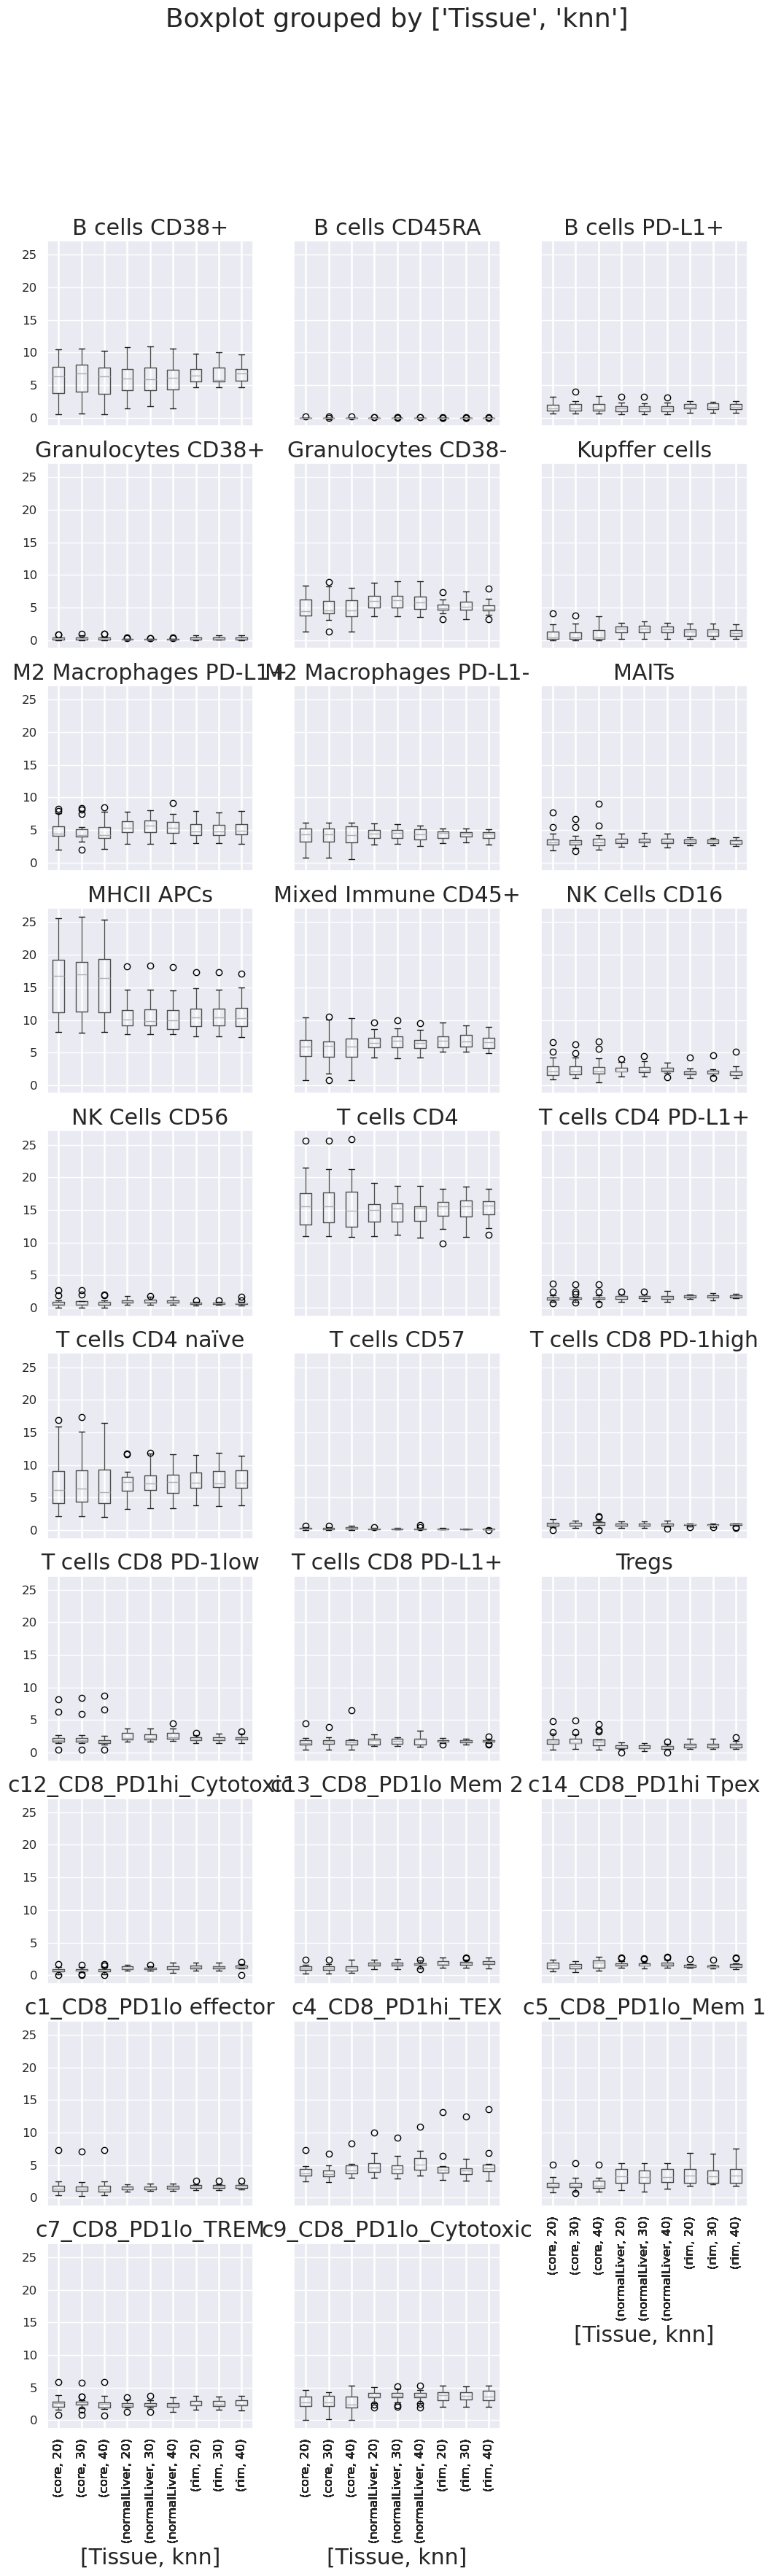

In [341]:
figure = plt.subplot

ax = (
    full_neighbor_df_norm_all[
        full_neighbor_df_norm_all["Cluster label"] == "c4_CD8_PD1hi_TEX"
    ]
    .groupby(["knn", "Patient", "Cluster label", "Tissue"])
    .mean()
    .boxplot(
        by=["Tissue", "knn"],
        layout=(10, 3),
        figsize=(3 * 4, 10 * 4),
        rot=90,
        fontsize=12,
    )
)

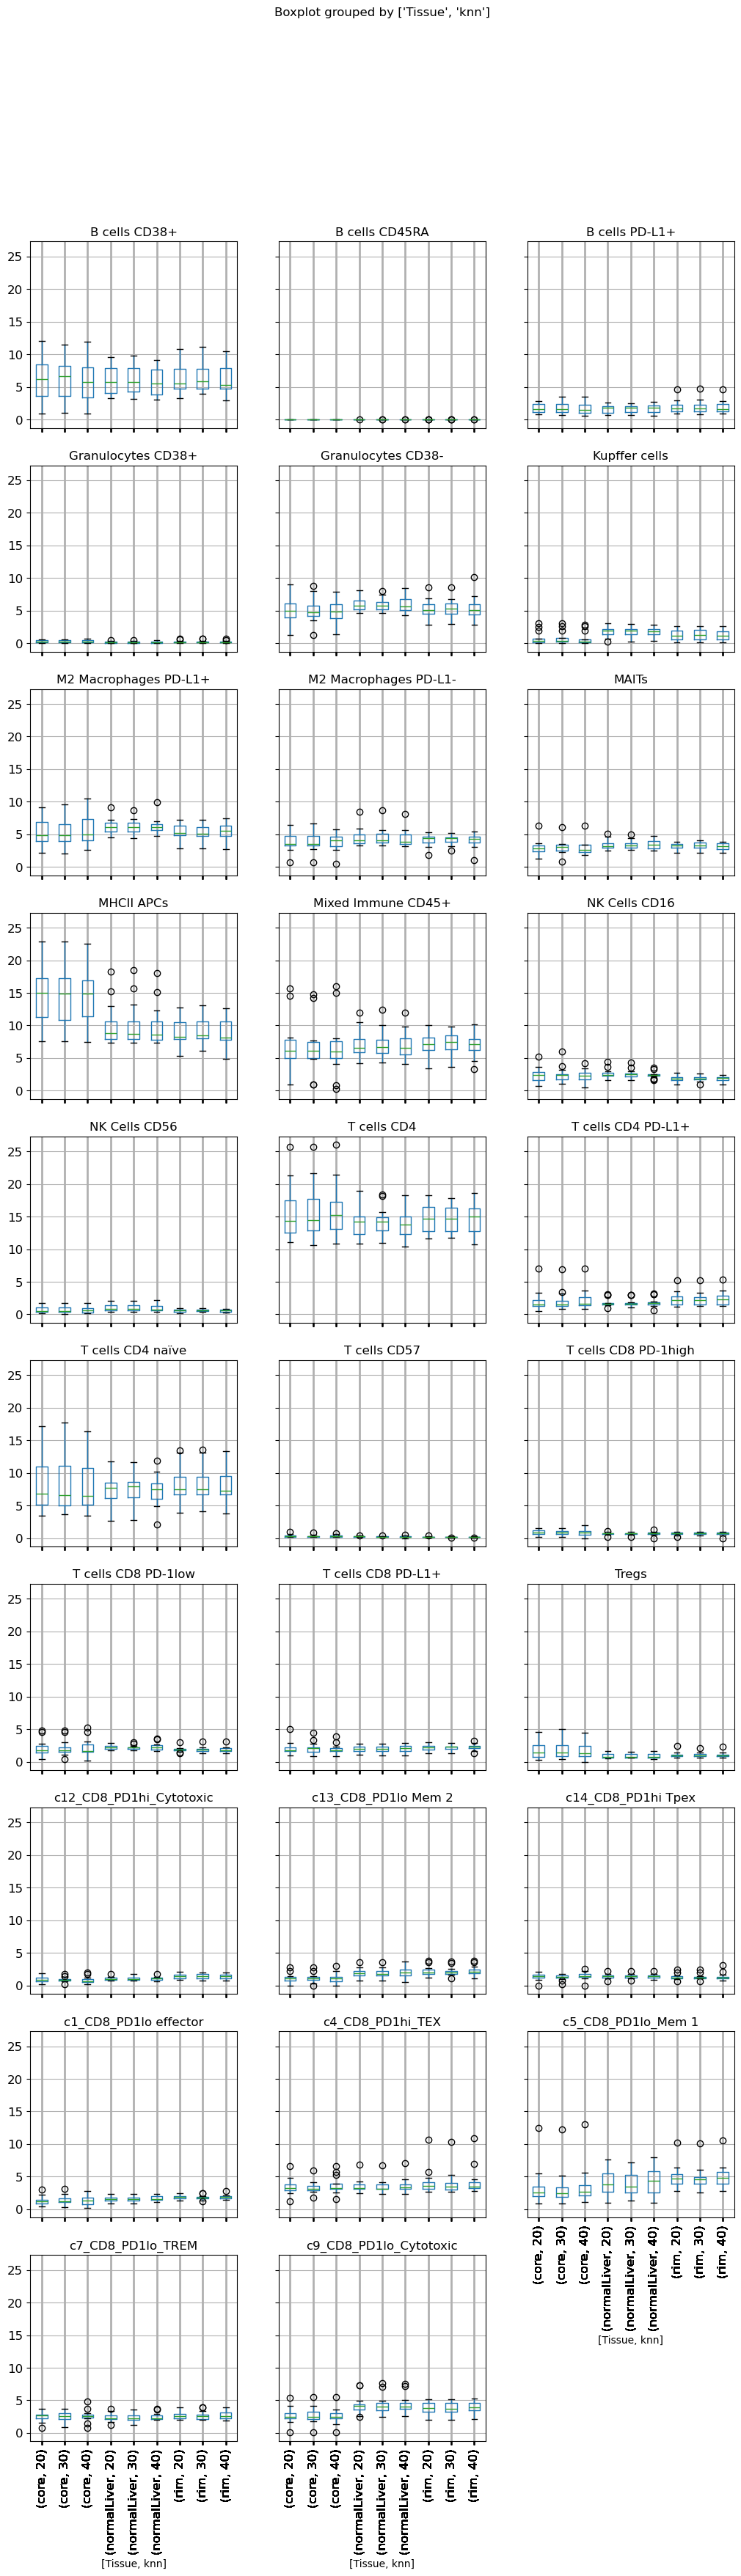

In [225]:
figure = plt.subplot

ax = (
    full_neighbor_df_norm_all[
        full_neighbor_df_norm_all["Cluster label"] == "c5_CD8_PD1lo_Mem 1"
    ]
    .groupby(["knn", "Patient", "Cluster label", "Tissue"])
    .mean()
    .boxplot(
        by=["Tissue", "knn"],
        layout=(10, 3),
        figsize=(3 * 4, 10 * 4),
        rot=90,
        fontsize=12,
    )
)

In [220]:
full_neighbor_df_norm_all["Cluster label"].unique()

array(['c9_CD8_PD1lo_Cytotoxic', 'c5_CD8_PD1lo_Mem 1', 'c4_CD8_PD1hi_TEX',
       'c14_CD8_PD1hi Tpex', 'c13_CD8_PD1lo Mem 2', 'c7_CD8_PD1lo_TREM',
       'c12_CD8_PD1hi_Cytotoxic', 'c1_CD8_PD1lo effector'], dtype=object)

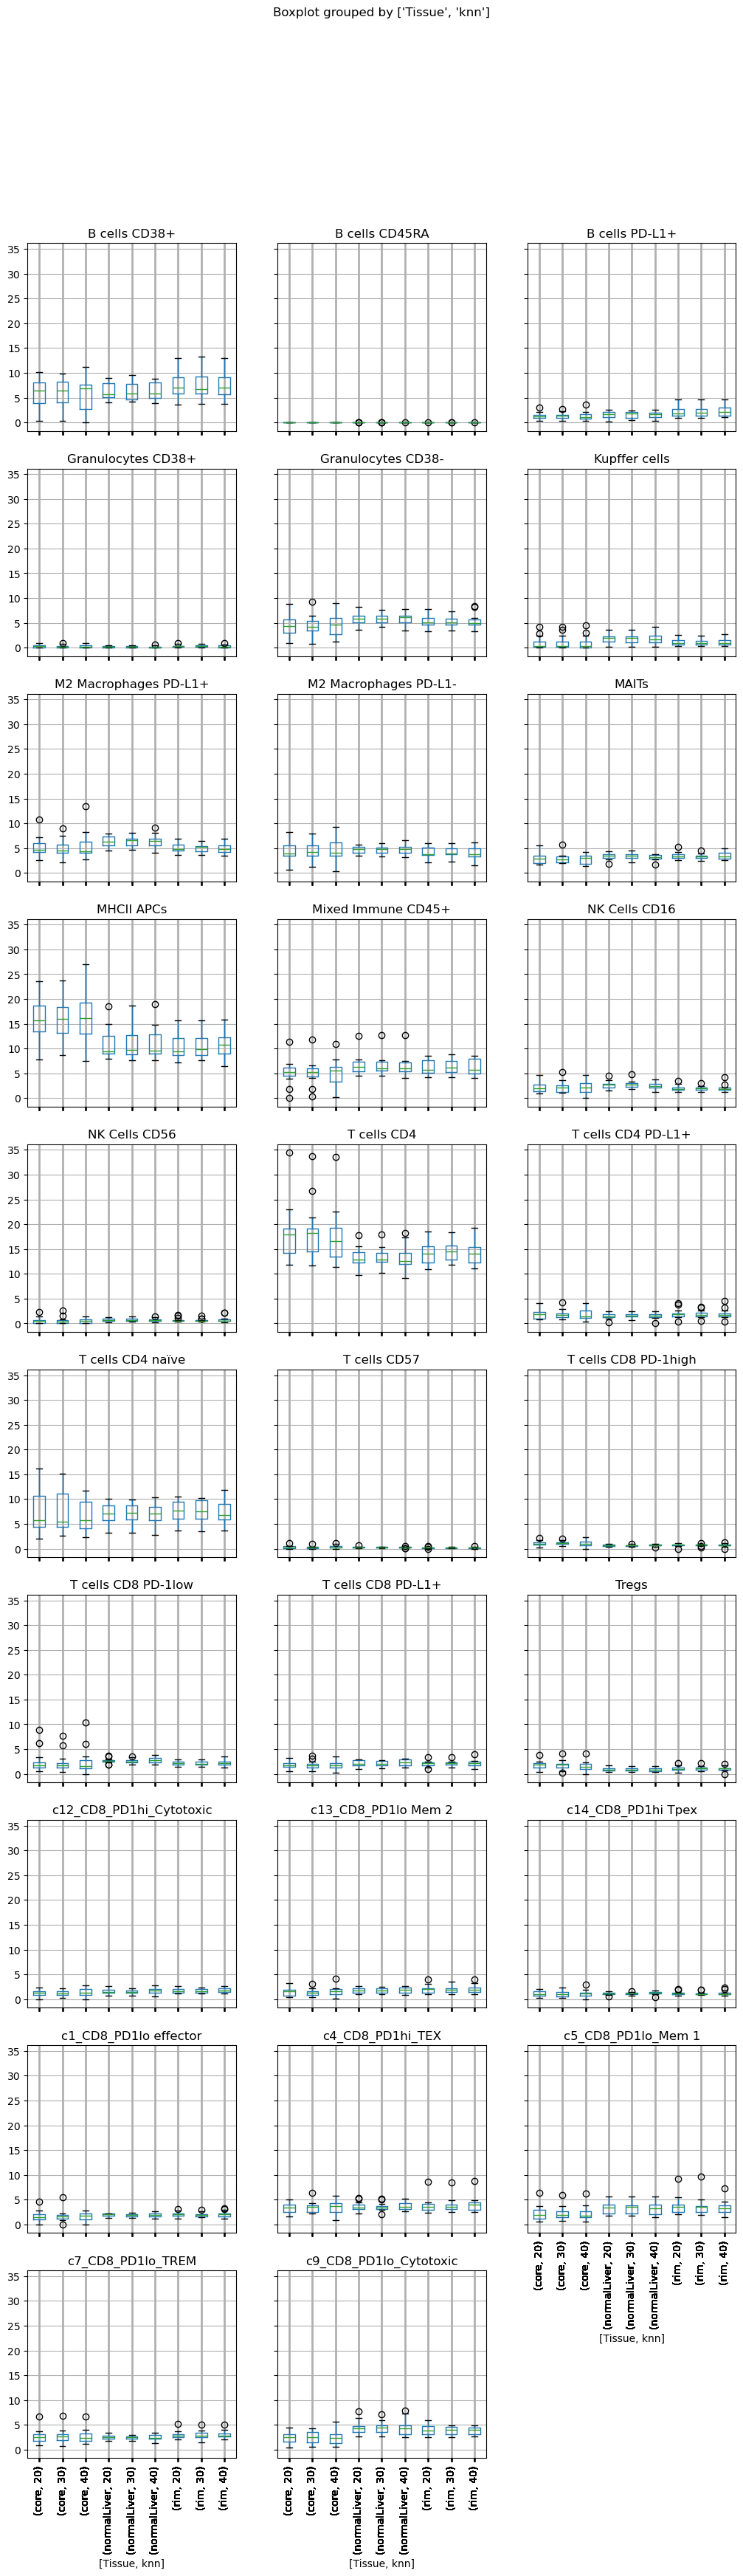

In [221]:
figure = plt.subplot

ax = (
    full_neighbor_df_norm_all[
        full_neighbor_df_norm_all["Cluster label"] == "c12_CD8_PD1hi_Cytotoxic"
    ]
    .groupby(["knn", "Patient", "Cluster label", "Tissue"])
    .mean()
    .boxplot(by=["Tissue", "knn"], layout=(10, 3), figsize=(3 * 4, 10 * 4), rot=90)
)

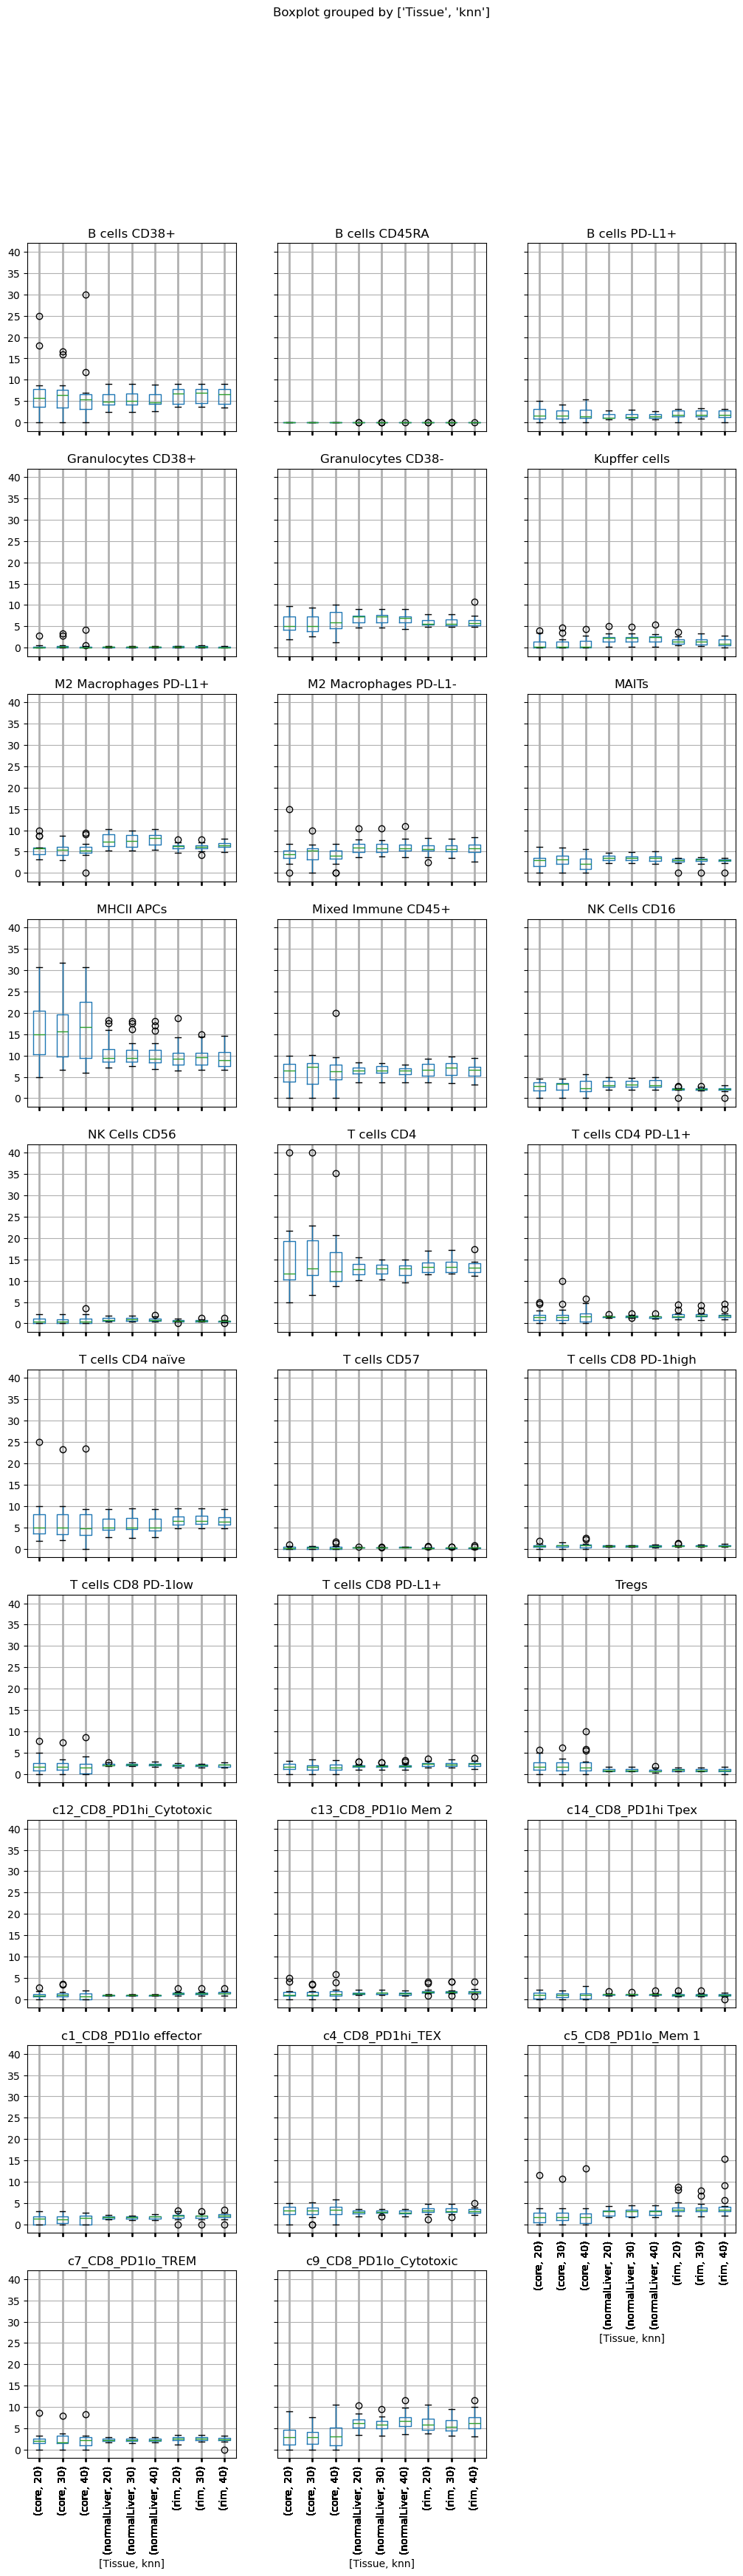

In [222]:
figure = plt.subplot

ax = (
    full_neighbor_df_norm_all[
        full_neighbor_df_norm_all["Cluster label"] == "c9_CD8_PD1lo_Cytotoxic"
    ]
    .groupby(["knn", "Patient", "Cluster label", "Tissue"])
    .mean()
    .boxplot(by=["Tissue", "knn"], layout=(10, 3), figsize=(3 * 4, 10 * 4), rot=90)
)